First load the Spotify dataset. Your task will be to predict the popularity of a song based on various audio features, like 'tempo', 'danceability', and 'mode'.

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

In [4]:
spotify = pd.read_csv('spotify.csv')
spotify.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


In [5]:
spotify.shape

(32833, 23)

In [11]:
spotify.columns

Index(['track_id', 'track_name', 'track_artist', 'track_popularity',
       'track_album_id', 'track_album_name', 'track_album_release_date',
       'playlist_name', 'playlist_id', 'playlist_genre', 'playlist_subgenre',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms'],
      dtype='object')

In [7]:
spotify.isnull().sum()

track_id                    0
track_name                  5
track_artist                5
track_popularity            0
track_album_id              0
track_album_name            5
track_album_release_date    0
playlist_name               0
playlist_id                 0
playlist_genre              0
playlist_subgenre           0
danceability                0
energy                      0
key                         0
loudness                    0
mode                        0
speechiness                 0
acousticness                0
instrumentalness            0
liveness                    0
valence                     0
tempo                       0
duration_ms                 0
dtype: int64

In [8]:
X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

In [9]:
X.isnull().sum()

track_id                    0
track_name                  0
track_artist                0
track_album_id              0
track_album_name            0
track_album_release_date    0
playlist_name               0
playlist_id                 0
playlist_genre              0
playlist_subgenre           0
danceability                0
energy                      0
key                         0
loudness                    0
mode                        0
speechiness                 0
acousticness                0
instrumentalness            0
liveness                    0
valence                     0
tempo                       0
duration_ms                 0
dtype: int64

In [13]:
X.dtypes

track_id                     object
track_name                   object
track_artist                 object
track_album_id               object
track_album_name             object
track_album_release_date     object
playlist_name                object
playlist_id                  object
playlist_genre               object
playlist_subgenre            object
danceability                float64
energy                      float64
key                           int64
loudness                    float64
mode                          int64
speechiness                 float64
acousticness                float64
instrumentalness            float64
liveness                    float64
valence                     float64
tempo                       float64
duration_ms                   int64
dtype: object

In [14]:
features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

In [15]:
preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

In [16]:
# We'll do a "grouped" split to keep all of an artist's songs in one
# split or the other. This is to help prevent signal leakage.
def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

In [17]:
X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

In [18]:
X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100 # popularity is on a scale 0-100, so this rescales to 0-1.
y_valid = y_valid / 100

In [19]:
input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [18]


Let's start with the simplest network, a linear model. This model has low capacity.

Run this next cell without any changes to train a linear model on the Spotify dataset.

In [22]:
model = keras.Sequential([
    layers.Dense(1, input_shape=input_shape),
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0, # suppress output since we'll plot the curves
)

Minimum Validation Loss: 0.1953


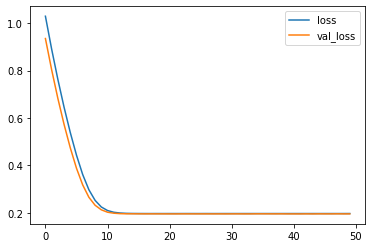

In [23]:
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

It's not uncommon for the curves to follow a "hockey stick" pattern like you see here. This makes the final part of training hard to see, so let's start at epoch 10 instead:

Minimum Validation Loss: 0.1953


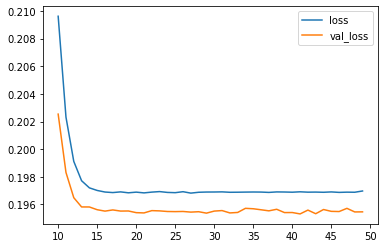

In [24]:
# Start the plot at epoch 10
history_df.loc[10:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

### 1) Evaluate Baseline

The gap between these curves is quite small and the validation loss never increases, so it's more likely that the network is underfitting than overfitting. It would be worth experimenting with more capacity to see if that's the case.

Now let's add some capacity to our network. We'll add three hidden layers with 128 units each. Run the next cell to train the network and see the learning curves.

In [25]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
)

Epoch 1/50
49/49 [==============================] - 0s 3ms/step - loss: 0.2812 - val_loss: 0.2091
Epoch 2/50
49/49 [==============================] - 0s 2ms/step - loss: 0.2031 - val_loss: 0.2024
Epoch 3/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1975 - val_loss: 0.2009
Epoch 4/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1945 - val_loss: 0.1978
Epoch 5/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1927 - val_loss: 0.1980
Epoch 6/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1910 - val_loss: 0.1982
Epoch 7/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1894 - val_loss: 0.1964
Epoch 8/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1882 - val_loss: 0.1957
Epoch 9/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1870 - val_loss: 0.1960
Epoch 10/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1861 - val_loss: 0.1949
Epoch 11/50
49/49 [

Minimum Validation Loss: 0.1949


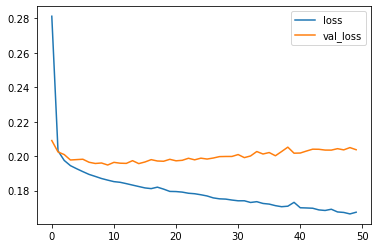

In [26]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

### 2) Add Capacity

Now the validation loss begins to rise very early, while the training loss continues to decrease. This indicates that the network has begun to overfit. At this point, we would need to try something to prevent it, either by reducing the number of units or through a method like early stopping. (We'll see another in the next lesson!)

### 3) Define Early Stopping Callback

Now define an early stopping callback that waits 5 epochs (patience') for a change in validation loss of at least 0.001 (min_delta) and keeps the weights with the best loss (restore_best_weights).

In [28]:
early_stopping = callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

Now run this cell to train the model and get the learning curves. Notice the callbacks argument in model.fit.

In [29]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),    
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
49/49 [==============================] - 0s 3ms/step - loss: 0.2327 - val_loss: 0.2071
Epoch 2/50
49/49 [==============================] - 0s 2ms/step - loss: 0.2002 - val_loss: 0.2022
Epoch 3/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1954 - val_loss: 0.1992
Epoch 4/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1924 - val_loss: 0.2001
Epoch 5/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1911 - val_loss: 0.2008
Epoch 6/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1900 - val_loss: 0.1986
Epoch 7/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1882 - val_loss: 0.1984
Epoch 8/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1868 - val_loss: 0.1976
Epoch 9/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1859 - val_loss: 0.1980
Epoch 10/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1851 - val_loss: 0.1987
Epoch 11/50
49/49 [

Minimum Validation Loss: 0.1966


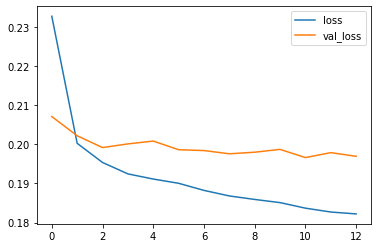

In [30]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

### 4) Train and Interpret

The early stopping callback did stop the training once the network began overfitting. Moreover, by including restore_best_weights we still get to keep the model where validation loss was lowest.